# Import section

In [1]:
from sys import exit
import importlib

from astropy.io import ascii as asci
from astropy.io.votable import is_votable, parse
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import numpy as np
            
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from matplotlib.markers import MarkerStyle

from cosmolopy.distance import comoving_distance_transverse
cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'omega_k_0' : 0.0, 'h' : 0.72}

from stage2 import *

# DATA TREATMENT SECTION

## Checking that file format is correct

In [118]:
pathdata = "outputs/"
data     = ["matching_fieldGals_Cassata_and_Zurich_corrected_radius_v2.vot"]

for name in data:
    voTag = is_VOtable(pathdata+name)
    if voTag:        
        fullFileName = pathdata + name
        #Retrieving the data
        table = parse(fullFileName)
        full  = table.get_first_table()
        
        print("Size of", name, "is", full.array.shape[0], "\n")
    else:
        exit("Exiting")

The file outputs/matching_fieldGals_Cassata_and_Zurich_corrected_radius_v2.vot is a VOtable, right ? True
Size of matching_fieldGals_Cassata_and_Zurich_corrected_radius_v2.vot is 261 



## Getting data

In [119]:
catalog = parse(pathdata+data[0]).get_first_table().array
fields  = np.asarray(catalog.dtype.names)

#Checking that the matching procedure did not duplicate galaxies
checkDupplicates([catalog], names=["matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot"])

#Converting to an astropy table for simplicity
table = Table(catalog)      

printSimpleStat([catalog['Separation_ZURICH']], unit=u.arcsec)
print("\nNumber of galaxies in matching catalog:", np.shape(table)[0])

All the galaxies are only listed once in the catalog matching_fieldGals_Cassata_and_Zurich_corrected_radius.vot
Stat for catalog number 0 :
Maximum separation is 0.66913126003908 arcsec.
Mean separation is -3256.312416442096 arcsec.
Median separation is 0.04296047126367109 arcsec.
1st quantile is -9999.0.
3rd quantile is 0.09477883642092895.

Number of galaxies in matching catalog: 261


## Correlation between Flux(OII) and SNR

### Getting OII flux and flux error to compute SNR

In [12]:
redshift = table['Z_MUSE']
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

### Checking and removing nan values in tables

In [13]:
m = maskToRemoveVal([fluxOII, errflux], astroTableMask=True)
m = np.logical_and(m, maskToRemoveVal([fluxOII, errflux]))

fluxOII, errflux, redshift = applyMask([fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux])

No nan was found in array number 0
No nan was found in array number 1


[False, False]

### Computing SNR

In [14]:
SNR     = fluxOII/errflux

### Plotting Flux(OII) vs SNR

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cb4efbcf8>,
 <matplotlib.collections.PathCollection at 0x7f4cb4ee4e10>)

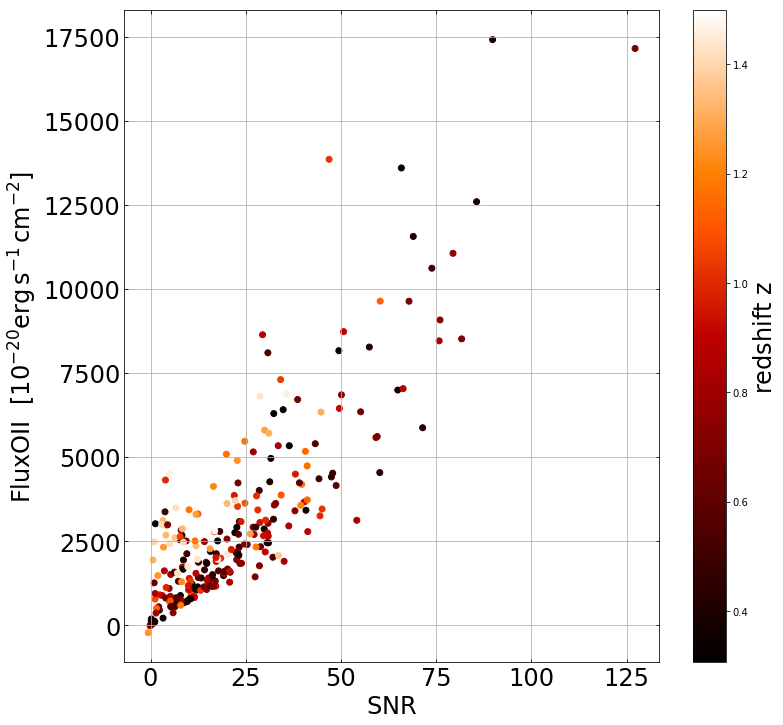

In [16]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

asManyPlots(111, SNR, fluxOII, xlabel=r'$\rm{SNR}$', ylabel=r'$\rm{Flux OII \ \ [10^{-20} erg \, s^{-1} \, cm^{-2}]}$',
            plotFlag=False, color=[redshift], marker='o', cmap='gist_heat', 
            showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/Flux_vs_SNR.pdf', overwrite=True)

## Plotting size against mass

### Getting data

In [17]:
#Converting size in arcsec
size                  = table['Corrected_radius']*0.03
redshift              = table['Z_MUSE']
lmass                 = table['lmass']

#Useful to compute SNR to make a cut
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size, lmass], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size, lmass]))

lmass, size, fluxOII, errflux, redshift = applyMask([lmass, size, fluxOII, errflux, redshift], m)
findWhereIsValue([fluxOII, errflux, size, lmass])

#Compute SNR
SNR     = fluxOII/errflux

#Apply relevant cut
m       = np.logical_and(SNR>10, size>=0.35)
zFromGalsWeWant, sizeGalsWeWant, lmassGalsWeWant = applyMask([redshift, size, lmass], m)

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3


### Converting size from arcsec to kpc

In [18]:
#Transforming from arcsec to radians
sizeGalsWeWant /= 3600 #arcsec to degrees
sizeGalsWeWant *= np.pi/180.0 #degrees to radians

#Transforming angular size in comsological transverse size
sizeGalsWeWant *= comoving_distance_transverse(zFromGalsWeWant, **cosmo)
sizeGalsWeWant *= 1.0e3 #Mpc to kpc

### Plotting

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cb54952b0>,
 <matplotlib.collections.PathCollection at 0x7f4cb3d9e940>)

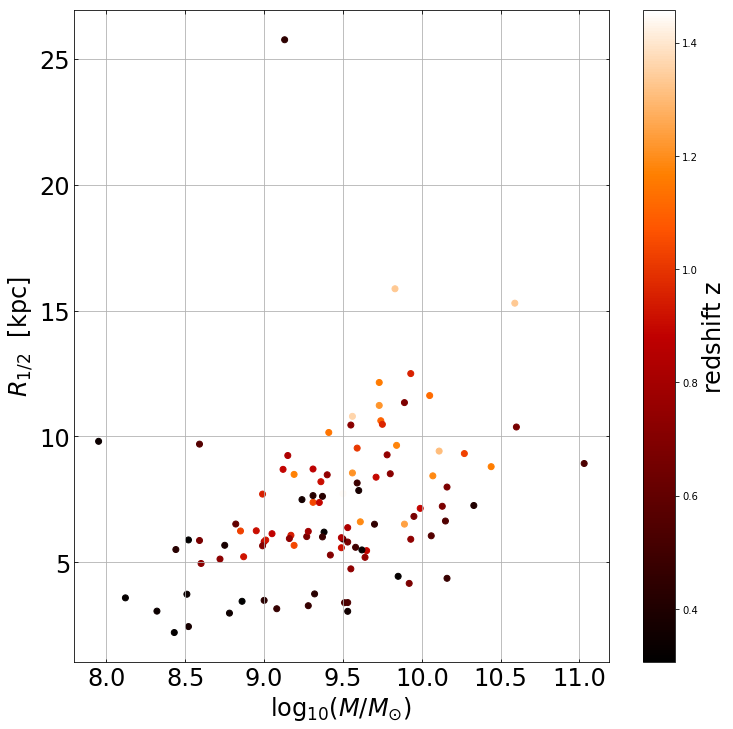

In [20]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

asManyPlots(111, lmassGalsWeWant, sizeGalsWeWant, xlabel=r'$\log_{10} (M/M_{\odot})$', ylabel=r'$R_{1/2} \ \ [\rm{kpc}]$',
            plotFlag=[False], color=[zFromGalsWeWant], marker=['o'],
            cmap='gist_heat', showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/size_vs_log10Mass.pdf', overwrite=False)

## SNR vs size (arcsec)

### Getting data and Computing SNR

In [21]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

size, fluxOII, errflux, redshift = applyMask([size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Plotting SNR vs size (in arcsec)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cb1c0e518>,
 [<matplotlib.lines.Line2D at 0x7f4cb18b6278>])

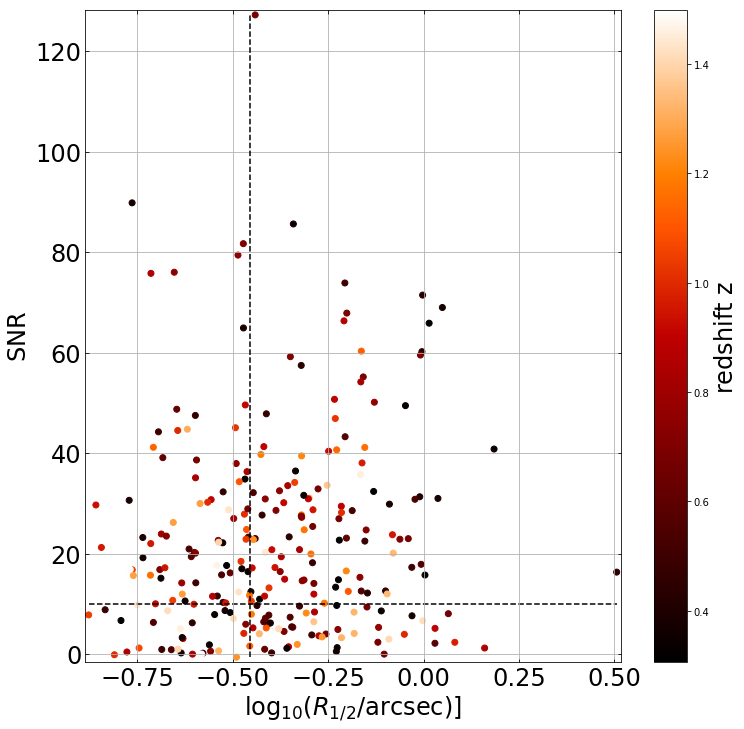

In [23]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

lsize =  np.log10(size)

SNRLineX = [np.min(lsize), np.max(lsize)]
SNRLineY = [10, 10]

lszLineX = [np.log10(0.35), np.log10(0.35)]
lszLineY = [np.min(SNR), np.max(SNR)]

asManyPlots(111, [lsize, SNRLineX, lszLineX], [SNR, SNRLineY, lszLineY], 
            ylabel=r'$\rm{SNR}$', xlabel=r'$\log_{10} (R_{1/2} / \rm{arcsec})]$',
            plotFlag=[False, True, True], color=[redshift, 'k', 'k'], zorder=[0,1,2],
            marker=['o', 'None', 'None'], linestyle=['None', 'dashed', 'dashed'],
            cmap='gist_heat', showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/SNR_vs_R_halfLight_arcsec.pdf', overwrite=False,
            xlim=[np.min(lsize)-0.01, np.max(lsize)+0.01],
            ylim=[np.min(SNR)-1, np.max(SNR)+1])

## SNR vs comoving transverse distance

### Getting data and Computing SNR

In [29]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

size, fluxOII, errflux, redshift = applyMask([size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

#Transforming from arcsec to radians
size /= 3600 #arcsec to degrees
size *= np.pi/180.0 #degrees to radians

#Transforming angular size in comsological transverse size
size *= comoving_distance_transverse(redshift, **cosmo)
size *= 1.0e3 #Mpc to kpc

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Plotting SNR vs comoving transverse distance

(<matplotlib.axes._subplots.AxesSubplot at 0x7f4cb1439320>,
 [<matplotlib.lines.Line2D at 0x7f4cb14e7470>])

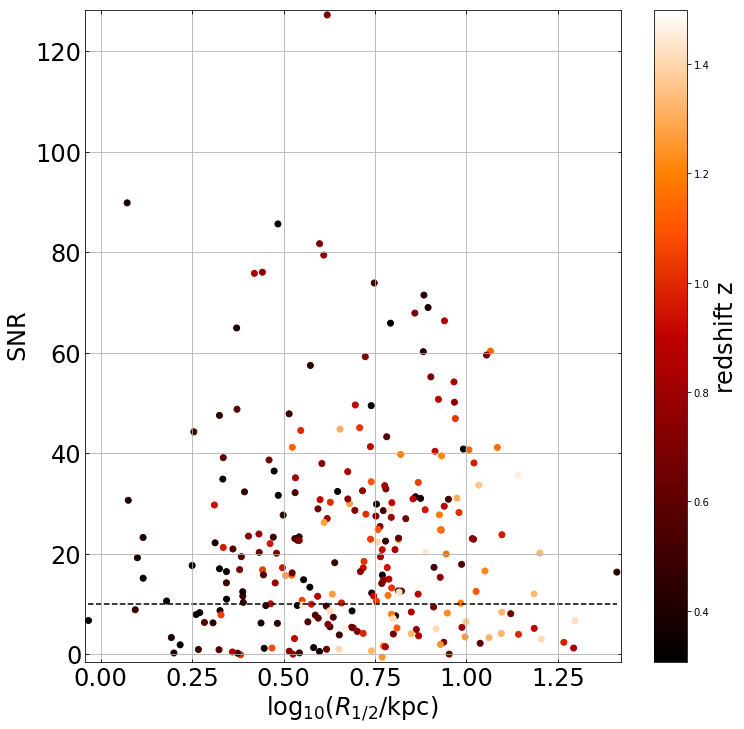

In [32]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

lsize =  np.log10(size)

SNRLineX = [np.min(lsize), np.max(lsize)]
SNRLineY = [10, 10]

asManyPlots(111, [lsize, SNRLineX], [SNR, SNRLineY], 
            ylabel=r'$\rm{SNR}$', xlabel=r'$\log_{10}(R_{1/2} / \rm{kpc})$',
            plotFlag=[False, True], color=[redshift, 'k'], zorder=[0,1],
            marker=['o', 'None', 'None'], linestyle=['None', 'dashed', 'dashed'],
            cmap='gist_heat', showColorbar=True, colorbarLabel=r'$\rm{redshift \,\, z}$',
            outputName='Plots/Selection_plots/SNR_vs_R_halfLight_kpc.pdf', overwrite=False,
            xlim=[np.min(lsize)-0.01, np.max(lsize)+0.01],
            ylim=[np.min(SNR)-1, np.max(SNR)+1])

## Redshift histograms

### Getting data and Computing SNR

In [36]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

size, fluxOII, errflux, redshift = applyMask([size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Splitting data into gals we want and gals we do not want

In [37]:
zFromGalsWeWant  = redshift[np.logical_and(SNR>10, size>=0.35)]
zFromGalsNotWant = redshift[np.logical_or(SNR<=10, size<0.35)]

meanZ = np.mean(zFromGalsWeWant)

print("Number of gals without cuts", np.shape(redshift)[0])
print("Number of gals", np.shape(zFromGalsWeWant)[0])
print("Mean redshift", np.mean(zFromGalsWeWant))
print("Median redshift", np.median(zFromGalsWeWant))

Number of gals without cuts 258
Number of gals 103
Mean redshift 0.7494067590213517
Median redshift 0.7188599705696106


### Plotting histograms

0.10847545
0.10847548
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545
0.10847545


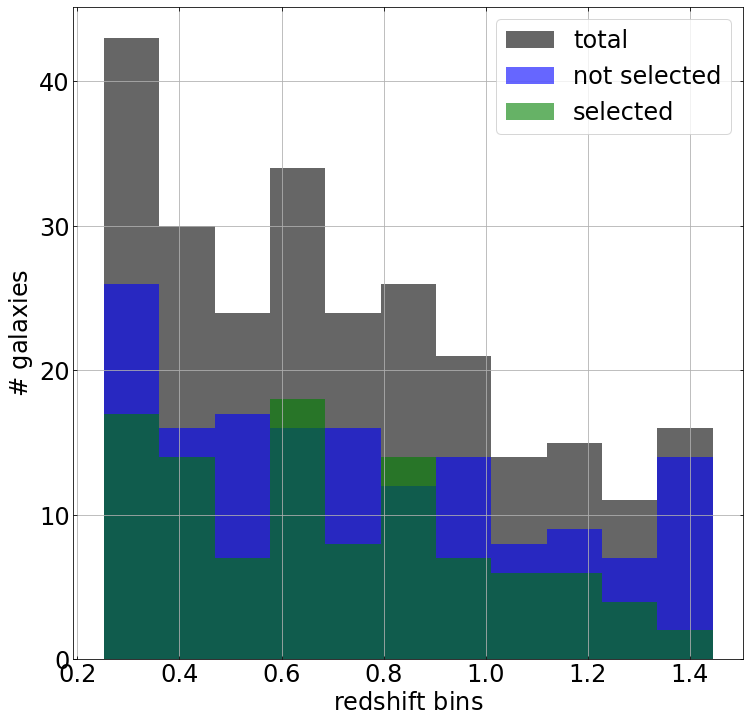

In [42]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)


[zFromGalsNotWant, zFromGalsWeWant]
['black', 'red']
['red', 'black']
label=['not selected', 'selected']

zTot = np.append(zFromGalsNotWant, zFromGalsWeWant)

#Trying to have bins around 0.1 in width
bins = int((np.max(zFromGalsWeWant)-np.min(zFromGalsWeWant))/0.1)
ax, n, bns = asManyHists(111, [zFromGalsWeWant, zFromGalsNotWant, zTot], bins=bins,
                        xlabel=r'$\rm{redshift \,\, bins}$', ylabel=r'$\rm{\# \,\, galaxies}$',
                        color=['green', 'blue', 'black'], histtype='stepfilled', align='left',
                        label=['selected', 'not selected', 'total'], showLegend=True, alpha=0.6,
                        outputName='Plots/Selection_plots/hist_redshift.pdf', overwrite=False)

#Check bins are correct
for i in range(len(bns)-1):
    print(bns[i+1]-bns[i])

### Plotting cumulative distribution

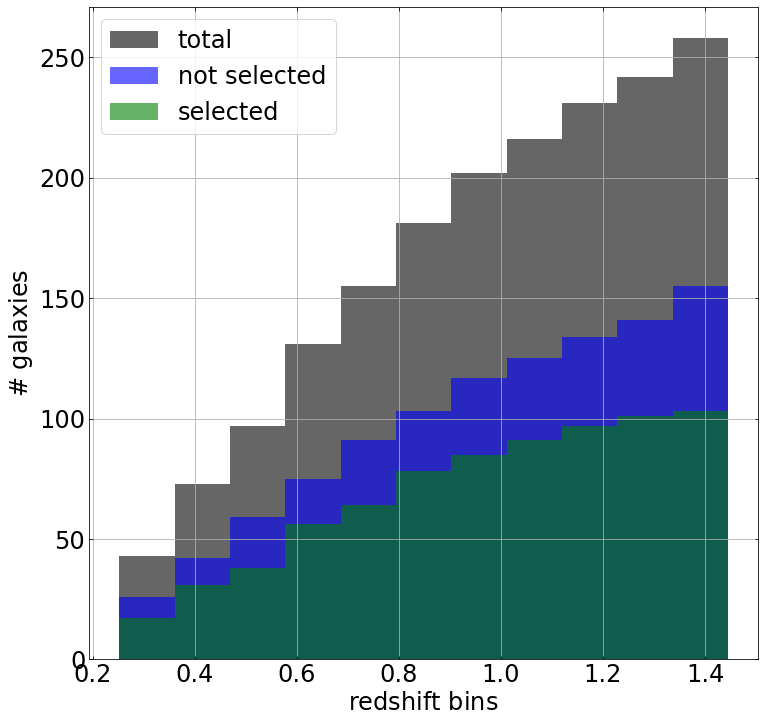

In [46]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)


[zFromGalsNotWant, zFromGalsWeWant]
['black', 'red']
['red', 'black']
label=['not selected', 'selected']

zTot = np.append(zFromGalsNotWant, zFromGalsWeWant)

#Trying to have bins around 0.1 in width
bins = int((np.max(zFromGalsWeWant)-np.min(zFromGalsWeWant))/0.1)
ax, n, bns = asManyHists(111, [zFromGalsWeWant, zFromGalsNotWant, zTot], bins=bins,
                        xlabel=r'$\rm{redshift \,\, bins}$', ylabel=r'$\rm{\# \,\, galaxies}$',
                        color=['green', 'blue', 'black'], histtype='stepfilled', align='left',
                        label=['selected', 'not selected', 'total'], showLegend=True, alpha=0.6,
                        outputName='Plots/Selection_plots/cumulative_hist_redshift.pdf', overwrite=False,
                        cumulative=True,
                        locLegend='upper left')

## CosmosID histograms

### Getting data and Computing SNR

In [6]:
cosmoID  = table['COSMOS_Group_Number']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size, cosmoID], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size, cosmoID]))

cosmoID, size, fluxOII, errflux = applyMask([cosmoID, size, fluxOII, errflux], m)

findWhereIsValue([fluxOII, errflux, size, cosmoID])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3


### Splitting data into gals we want and gals we do not want

In [7]:
IDWant    = cosmoID[np.logical_and(SNR>10, size>=0.35)]
IDNotWant = cosmoID[np.logical_or(SNR<=10, size<0.35)]

### Plotting histogram of COSMOS ID

In [26]:
bins = range(int(np.max([np.max(IDWant), np.max(IDNotWant), np.max(IDTot)])))
print(bins)

range(0, 114)


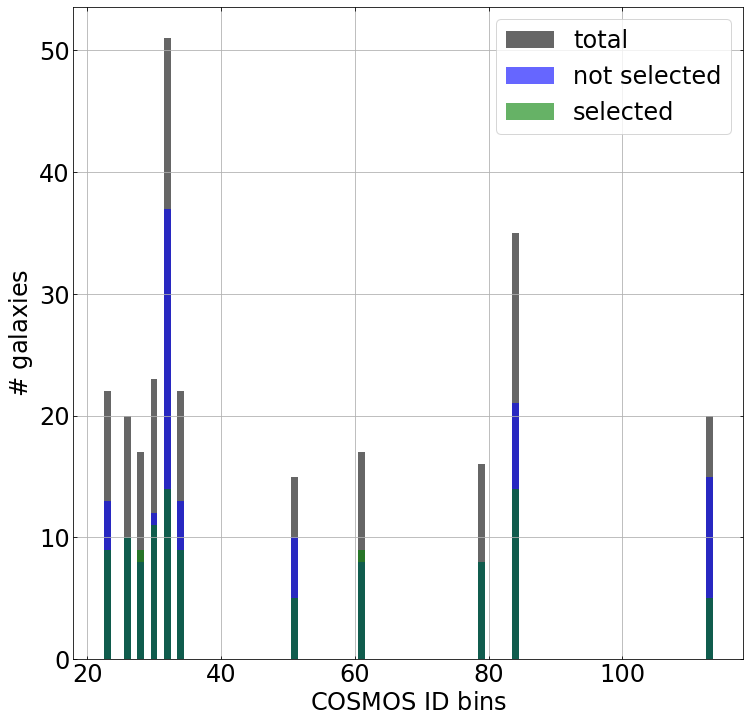

In [34]:
plt.rcParams["figure.figsize"] = (12, 12) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)


['black', 'red']
['red', 'black']
label=['not selected', 'selected']

IDTot = np.append(np.asarray(IDWant), np.asarray(IDNotWant))

#Trying to have bins around 0.1 in width
bins = range(int(np.min(IDTot)), int(np.max(IDTot)+1))
ax, n, bns = asManyHists(111, [IDWant, IDNotWant, IDTot], bins=bins,
                        xlabel=r'$\rm{COSMOS \,\, ID \,\, bins}$', ylabel=r'$\rm{\# \,\, galaxies}$',
                        color=['green', 'blue', 'black'], histtype='stepfilled', align='left',
                        label=['selected', 'not selected', 'total'], showLegend=True, alpha=0.6,
                        outputName='Plots/Selection_plots/hist_COSMOSID.pdf', overwrite=False)

## SFR vs mass (with FAST values)

### Getting data and Computing SNR

In [60]:
#Converting size in arcsec
size                  = table['Corrected_radius']*0.03
redshift              = table['Z_MUSE']
lmass                 = table['lmass']
lsfr                  = table['lsfr']

#Useful to compute SNR to make a cut
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

lsfr, lmass, size, fluxOII, errflux, redshift = applyMask([lsfr, lmass, size, fluxOII, errflux, redshift], m)
findWhereIsValue([fluxOII, errflux, size, lmass, lsfr])

#Compute SNR
SNR     = fluxOII/errflux

#Apply relevant cut
m       = np.logical_and(SNR>10, size>=0.35)
zFromGalsWeWant, lsfrGalsWeWant, lmassGalsWeWant = applyMask([redshift, lsfr, lmass], m)

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([lsfrGalsWeWant, lmassGalsWeWant], astroTableMask=True),
                         maskToRemoveVal([lsfrGalsWeWant, lmassGalsWeWant]))

zFromGalsWeWant, lsfrGalsWeWant, lmassGalsWeWant = applyMask([zFromGalsWeWant, lsfrGalsWeWant, lmassGalsWeWant], m)
findWhereIsValue([lsfrGalsWeWant, lmassGalsWeWant])

meanZ = np.mean(zFromGalsWeWant)

print("\nNumber of gals", np.shape(zFromGalsWeWant)[0])
print("Mean redshift", np.mean(zFromGalsWeWant))
print("Median redshift", np.median(zFromGalsWeWant))

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2
No nan was found in array number 3
No nan was found in array number 4
No nan was found in array number 0
No nan was found in array number 1

Number of gals 103
Mean redshift 0.7494067590213517
Median redshift 0.7188599705696106


### Plotting SFR vs mass (with FAST values)

File Plots/Selection_plots/SFR_vs_mass.pdf already exists but overwritting was disabled. Thus exiting without writing.


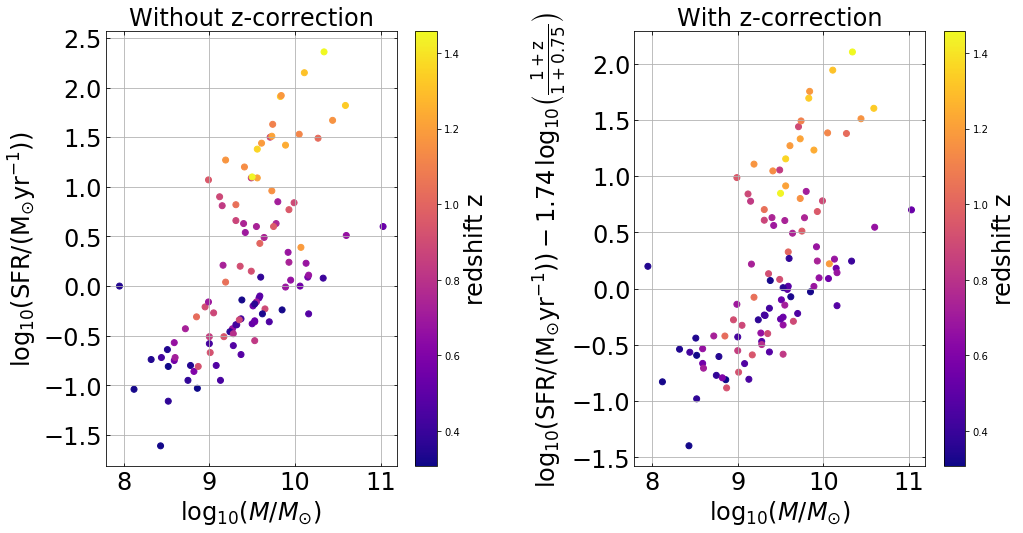

In [61]:
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

ax1, tmp = asManyPlots(121, lmassGalsWeWant, lsfrGalsWeWant,
                       ylabel=r'$\log_{10} (\rm{SFR}/(M_{\odot} \rm{yr}^{-1}))$',
                       xlabel=r'$\log_{10} ( M/M_{\odot})$',
                       marker='o', colorbarLabel=r'$\rm{redshift \,\, z}$',
                       showColorbar=True, plotFlag=False,
                       color=[zFromGalsWeWant],
                       cmap='plasma', title='Without z-correction', outputName='Plots/Selection_plots/SFR_vs_mass.pdf', overwrite=False)

correctedSfr = lsfrGalsWeWant - 1.74*np.log10((1+zFromGalsWeWant)/(1+meanZ))

ylabel   = r'$\log_{10} (\rm{SFR}/(M_{\odot} \rm{yr}^{-1})) - 1.74 \, \log_{10} \left ( \frac{1+z}{1+%.2f} \right )$' %meanZ
ax1, tmp = asManyPlots(122, lmassGalsWeWant, correctedSfr,
                       ylabel=ylabel,
                       xlabel=r'$\log_{10} ( M/M_{\odot})$',
                       marker='o', colorbarLabel=r'$\rm{redshift \,\, z}$',
                       showColorbar=True, plotFlag=False,
                       color=[zFromGalsWeWant],
                       cmap='plasma', title='With z-correction', outputName='Plots/Selection_plots/SFR_vs_mass.pdf', overwrite=False)

## SFR vs mass (with morphological values)

### Getting data and Computing SNR

In [55]:
#Converting size in arcsec
size                  = table['Corrected_radius']*0.03
redshift              = table['Z_MUSE']
massMed               = table['MASS_MED']
massBest              = table['MASS_BEST']
sfrMED                = table['SFR_MED']
sfrBEST               = table['SFR_BEST']

#Useful to compute SNR to make a cut
fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

#Compute and apply mask
m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

massMed, massBest, sfrMED, sfrBEST, size, fluxOII, errflux, redshift = applyMask([massMed, massBest, sfrMED, sfrBEST, 
                                                                                  size, fluxOII, errflux, redshift], m)
findWhereIsValue([fluxOII, errflux, size])

#Compute SNR
SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Checking median and best values for SFR and mass are similar

(<matplotlib.axes._subplots.AxesSubplot at 0x7fbb1195c080>,
 [<matplotlib.lines.Line2D at 0x7fbb120ce3c8>])

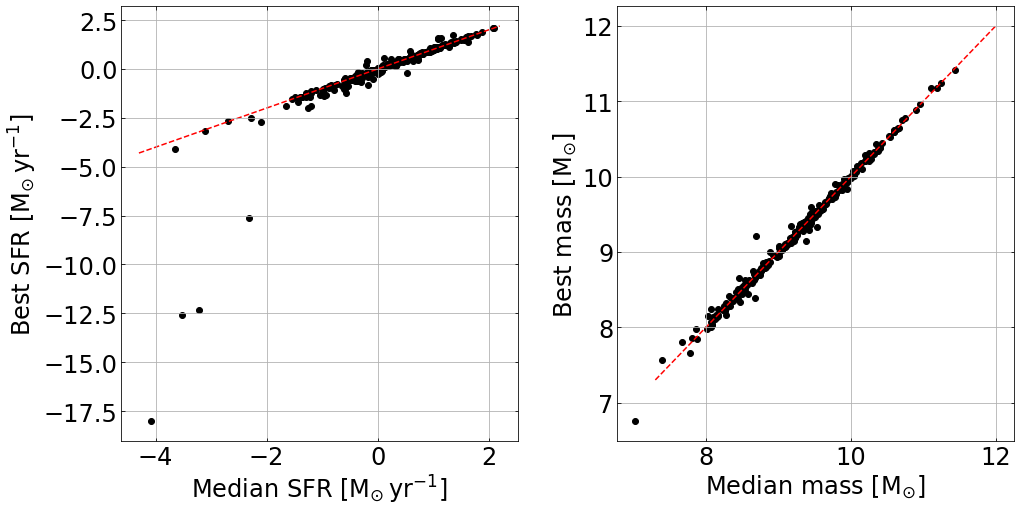

In [48]:
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.25, hspace=0.05)

xLine = [-4.3, 2.2]
yLine = xLine
asManyPlots(121, [sfrMED, xLine], [sfrBEST, yLine], 
            xlabel=r'$\rm{Median \,\, SFR \,\, [M_{\odot} \, yr^{-1}]}$', ylabel=r'$\rm{Best \,\, SFR \,\, [M_{\odot} \, yr^{-1}]}$',
            marker=['o', 'None'], linestyle=['None', '--'], color=['k', 'r'])

xLine = [7.3, 12]
yLine = xLine
asManyPlots(122, [massMed, xLine], [massBest, yLine], 
            xlabel=r'$\rm{Median \,\, mass \,\, [M_{\odot}]}$', ylabel=r'$\rm{Best \,\, mass \,\, [M_{\odot}]}$',
            marker=['o', 'None'], linestyle=['None', '--'], color=['k', 'r'],
            outputName='Plots/Selection_plots/comparingMorphoSFRsAndMasses.pdf', overwrite=False)

### Seperate gals we want

In [56]:
#Apply relevant cut
m       = np.logical_and(SNR>10, size>=0.35)
zFromGalsWeWant, sfrMedWeWant, massMedWeWant = applyMask([redshift, sfrMED, massMed], m)

#Remove potential nan values
m       = np.logical_and(maskToRemoveVal([sfrMedWeWant, massMedWeWant], astroTableMask=True),
                         maskToRemoveVal([sfrMedWeWant, massMedWeWant]))

zFromGalsWeWant, sfrMedWeWant, massMedWeWant = applyMask([zFromGalsWeWant, sfrMedWeWant, massMedWeWant], m)
findWhereIsValue([sfrMedWeWant, massMedWeWant])

meanZ = np.mean(zFromGalsWeWant)

print("\nNumber of gals", np.shape(zFromGalsWeWant)[0])
print("Mean redshift", np.mean(zFromGalsWeWant))
print("Median redshift", np.median(zFromGalsWeWant))

No nan was found in array number 0
No nan was found in array number 1

Number of gals 103
Mean redshift 0.7494067590213517
Median redshift 0.7188599705696106


### Plotting SFR vs mass (with morphological values)

File Plots/Selection_plots/SFR_vs_mass.pdf already exists but overwritting was disabled. Thus exiting without writing.


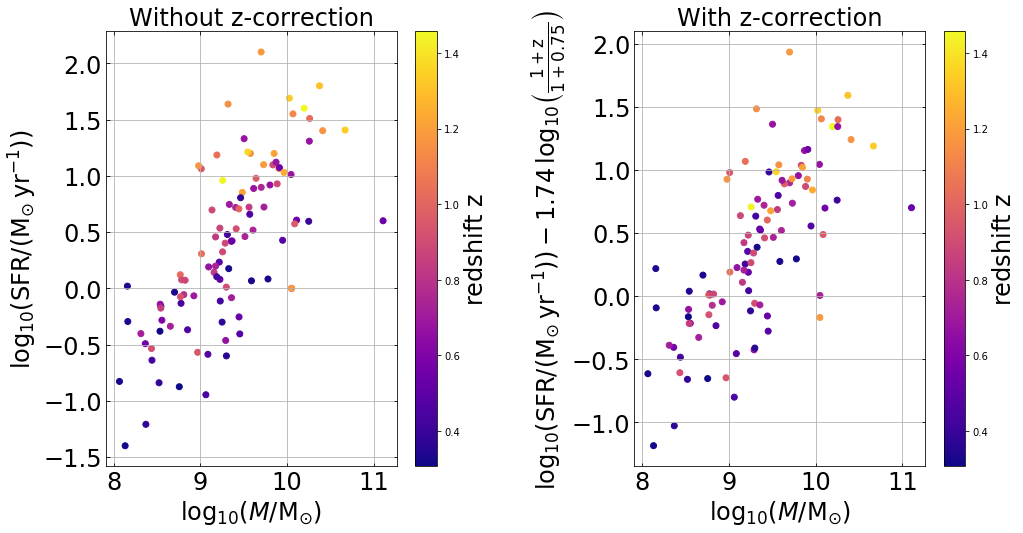

In [62]:
plt.rcParams["figure.figsize"] = (16, 8) # (w, h)
f = plt.figure()
plt.subplots_adjust(wspace=0.45, hspace=0.05)

ax1, tmp = asManyPlots(121, massMedWeWant, sfrMedWeWant,
                       ylabel=r'$\log_{10} (\rm{SFR}/(\rm{M_{\odot} \, yr}^{-1}))$',
                       xlabel=r'$\log_{10} ( M/\rm{M_{\odot}})$',
                       marker='o', colorbarLabel=r'$\rm{redshift \,\, z}$',
                       showColorbar=True, plotFlag=False,
                       color=[zFromGalsWeWant],
                       cmap='plasma', title='Without z-correction', outputName='Plots/Selection_plots/SFR_vs_mass.pdf', overwrite=False)

correctedSfr = sfrMedWeWant - 1.74*np.log10((1+zFromGalsWeWant)/(1+meanZ))

ylabel   = r'$\log_{10} (\rm{SFR}/(M_{\odot} \, \rm{yr}^{-1})) - 1.74 \, \log_{10} \left ( \frac{1+z}{1+%.2f} \right )$' %meanZ
ax1, tmp = asManyPlots(122, massMedWeWant, correctedSfr,
                       ylabel=ylabel,
                       xlabel=r'$\log_{10} ( M/\rm{M_{\odot}})$',
                       marker='o', colorbarLabel=r'$\rm{redshift \,\, z}$',
                       showColorbar=True, plotFlag=False,
                       color=[zFromGalsWeWant],
                       cmap='plasma', title='With z-correction', outputName='Plots/Selection_plots/SFR_vs_mass_withoutFAST.pdf', overwrite=False)

In [57]:
'Selecting galaxies around boths cuts'.upper()

'SELECTING GALAXIES AROUND BOTHS CUTS'

# SELECTING GALAXIES AROUND BOTHS CUTS

## Getting the list of galaxy IDs and COSMOS Group Number from the list_gal file in scripts_python_Benoit

In [148]:
path  = 'scripts_python_Benoit/'
file  = 'list_gal'
tbl   = asci.read(path+file, guess=False, format='no_header', fast_reader=True)

names = tbl['col1']
zFile = np.asarray(tbl['col2'])

tblGrNumbers = np.copy(names)
tblMUSEID    = np.copy(names)
for i, name in enumerate(names):
    
    #Getting group number of MUSE galaxies
    tblGrNumbers[i] = name.split('/')[2].split('_')[0].split('CGr')[1]
    if tblGrNumbers[i] in ['32-M1', '32-M2', '32-M3']:
        tblGrNumbers[i] = '32'
    if  tblGrNumbers[i] in ['84-N']:
        tblGrNumbers[i] = '84.1'
        
    #Getting MUSE galaxy IDs
    tblMUSEID[i] = name.split('/')[-1].split('_')[-2]
    
tblGrNumbers = np.asarray(tblGrNumbers, dtype='float')
tblMUSEID    = np.asarray(tblMUSEID, dtype='int')

## Selecting a few galaxies well resolved with a high SNR to test PyQubeVis

### Getting Cosmos group number and MUSE ID of selected galaxies

In [149]:
GroupNumber = np.asarray(table['COSMOS_Group_Number'], dtype='float')
ID_MUSE     = np.asarray(table['ID'], dtype='int')
zReduced    = np.asarray(table['Z_MUSE'], dtype='float')
rReduced    = np.asarray(table['Corrected_radius'], dtype='float')

### Computing SNR and applying mask

In [150]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

GroupNumber, ID_MUSE, zReduced, rReduced, size, fluxOII, errflux, redshift = applyMask([GroupNumber, ID_MUSE, zReduced, rReduced, 
                                                                                        size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Selecting galaxies

In [151]:
seeing      = 0.35 #arcsec
m           = np.where(np.logical_and(size>=2*seeing, SNR>=50))

GroupNumber = GroupNumber[m]
ID_MUSE     = ID_MUSE[m]
zReduced    = zReduced[m]

### Checking that the selected galaxies exist and have the relevant redshift. If they do, keep them

In [152]:
indices     = []
for i, gr, idm, zR in zip(range(len(zReduced)), GroupNumber, ID_MUSE, zReduced):
    m = np.logical_and(tblGrNumbers==gr, tblMUSEID==idm)
    if np.any(m):
        for j in np.where(m)[0]:
            indices.append(j)
        print('Galaxy CGr%5.1f_%3d number %2d was found with redshit difference %+1.5f' %(gr, idm, i, zR-zFile[m][0]))
    else:
        print('Galaxy CGr%5.1f_%3d number %2d not found' %(gr, idm, i))

print("\nGalaxy indices found in folders", indices)

namesWanted = names[indices]
zWanted     = zFile[indices]

Galaxy CGr 79.0_ 41 number  0 was found with redshit difference +0.00000
Galaxy CGr 32.0_232 number  1 was found with redshit difference -0.00000
Galaxy CGr114.0_ 79 number  2 was found with redshit difference -0.00000
Galaxy CGr114.0_ 99 number  3 was found with redshit difference +0.00000
Galaxy CGr 30.0_ 67 number  4 was found with redshit difference +0.00000
Galaxy CGr 30.0_ 91 number  5 was found with redshit difference -0.00000

Galaxy indices found in folders [117, 55, 229, 293, 1538, 1733, 1621, 1681]


### Write new list of gals into a file

In [153]:
outputFile = 'scripts_python_Benoit/galsWellResolved'

newTbl         = Table()
newTbl['name'] = np.asarray(namesWanted)
newTbl['z']    = np.asarray(zWanted)

# newTbl.write(outputFile, format='ascii.fixed_width_no_header', delimiter=None, formats={'name':'%-100s'}, overwrite=True)

## Keeping galaxies below the size cut, as far as 1 arcsec from the cut

### Getting Cosmos group number and MUSE ID of selected galaxies

In [154]:
GroupNumber = np.asarray(table['COSMOS_Group_Number'], dtype='float')
ID_MUSE     = np.asarray(table['ID'], dtype='int')
zReduced    = np.asarray(table['Z_MUSE'], dtype='float')
rReduced    = np.asarray(table['Corrected_radius'], dtype='float')

### Computing SNR and applying mask

In [155]:
redshift = table['Z_MUSE']

#Converting size in arcsec
size    = table['Corrected_radius']*0.03

fluxOII = table['OII_3726_FLUX'] + table['OII_3729_FLUX']
errflux = table['OII_3726_FLUX_ERR'] + table['OII_3729_FLUX_ERR']

m       = np.logical_and(maskToRemoveVal([fluxOII, errflux, size], astroTableMask=True),
                         maskToRemoveVal([fluxOII, errflux, size]))

GroupNumber, ID_MUSE, zReduced, rReduced, size, fluxOII, errflux, redshift = applyMask([GroupNumber, ID_MUSE, zReduced, rReduced, 
                                                                                        size, fluxOII, errflux, redshift], m)

findWhereIsValue([fluxOII, errflux, size])

SNR     = fluxOII/errflux

No nan was found in array number 0
No nan was found in array number 1
No nan was found in array number 2


### Selecting galaxies

In [156]:
deltaToCut   = 0.1 #arcsec

#Compute distance to cut and keep gals below the threshold but not too far from it
distToSNRCut = size - 0.35
m            = np.where(np.logical_and(distToSNRCut<0, distToSNRCut>=-deltaToCut))

GroupNumber  = GroupNumber[m]
ID_MUSE      = ID_MUSE[m]
zReduced     = zReduced[m]
rReduced     = rReduced[m]

### Checking that we have the correect size (i.e. we kept the right galaxies)

In [157]:
print("Difference between radius before and after selection:")
print(np.asarray(size[m]-(rReduced*0.03)))

Difference between radius before and after selection:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]


### Get matching between MUSE ID and ID_in_MUSE_Field which is used in the group number 84 folder to name galaxies

In [158]:
matchingFile = 'data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot'
is_VOtable(matchingFile)

tmpCOSMOSID   = parse(matchingFile).get_first_table().array['COSMOS_Group_Number']
m             = tmpCOSMOSID==84.0
CatalogMUSEID = parse(matchingFile).get_first_table().array['ID'][m]
FolderMUSEID  = parse(matchingFile).get_first_table().array['ID_in_MUSE_Field'][m]

The file data/catalogues/CGR84-83_FD+North_zcatalog_withLaigle+16_withFAST_withnewPLATEFIT_totalflux_withnewz_jan19_withFOF_withGALFIT_withGALKIN_jan19.vot is a VOtable, right ? True


### Checking that the selected galaxies exist and have the relevant redshift. If they do, keep them

In [159]:
indices     = []
for i, gr, idm, zR, r in zip(range(len(zReduced)), GroupNumber, ID_MUSE, zReduced, rReduced):
    if gr==84.0:
        idm = FolderMUSEID[np.where(CatalogMUSEID==idm)][0]
    
    m = np.logical_and(tblGrNumbers==gr, tblMUSEID==idm)
    if np.any(m):
        for j in np.where(m)[0]:
            indices.append(j)
        print('Galaxy CGr%5.1f_%3d number %2d was found with redshit difference %+1.5f and radius %2.2f px' %(gr, idm, i, zR-zFile[m][0], r))
    else:
        print('Galaxy CGr%5.1f_%3d number %2d not found' %(gr, idm, i))

print("\nGalaxy indices found in folders", indices)

namesWanted = names[indices]
zWanted     = zFile[indices]

Galaxy CGr 84.1_ 11 number  0 was found with redshit difference -0.00000 and radius 8.43 px
Galaxy CGr 84.0_ 47 number  1 was found with redshit difference -0.00000 and radius 9.45 px
Galaxy CGr 84.0_ 91 number  2 was found with redshit difference -0.00000 and radius 8.36 px
Galaxy CGr 84.0_119 number  3 was found with redshit difference -0.00000 and radius 8.65 px
Galaxy CGr 84.0_128 number  4 was found with redshit difference -0.00000 and radius 11.58 px
Galaxy CGr 84.0_138 number  5 was found with redshit difference -0.00000 and radius 9.92 px
Galaxy CGr 84.0_149 number  6 was found with redshit difference +0.00000 and radius 8.81 px
Galaxy CGr 34.0_ 81 number  7 was found with redshit difference +0.00000 and radius 10.06 px
Galaxy CGr 34.0_104 number  8 was found with redshit difference +0.00000 and radius 11.31 px
Galaxy CGr 34.0_134 number  9 was found with redshit difference +0.00000 and radius 10.88 px
Galaxy CGr 34.0_149 number 10 was found with redshit difference +0.00000 and

### Write new list of gals into a file

In [160]:
outputFile     = 'scripts_python_Benoit/galsBelowSizeCut'

newTbl         = Table()

newTbl['name'] = np.asarray(namesWanted)
newTbl['z']    = np.asarray(zWanted)

newTbl.write(outputFile, format='ascii.fixed_width_no_header', delimiter=None, formats={'name':'%-100s'}, overwrite=True)

print("Written.")

Written.
